# fly_data object : defined in working_functions.py

Things to implement in it :
    -more metadata ?

method the object should have :
    -output the object seen by the fly at a given time based on all the other fly object in the "session" (or just given a number of fly objects)

In [1]:
    ### Necessary modules

#for plots
import matplotlib.pyplot as plt


# trajectorytools needs to be installed. To installed follow the instructions 
# at http://www.github.com/fjhheras/trajectorytools
from trajectorytools.constants import dir_of_data
import trajectorytools as tt
import trajectorytools.plot as ttplot
import trajectorytools.socialcontext as ttsocial

#My functions
from data_processing import *
from graphing_data import *

#For importing files and timing cells.
import time
import matplotlib.mlab as mlab

Analysis function based on numerous fly_data objects from a single video :

    -position_summary: summarizes where we can find other flies relatively to our focus fly

    -A focus fly should be defined
    -Relative_fly object should be calculates based on the focus fly
    -What to calculate of this ?
    -Correlation between "turning" of the fly (derivation of orientation) and position of other flies ("global" position and specific position of every fly)

Landscape function ?:
    -Given a focus fly and a set of object, single-object projection of everything the fly sees ? 

In [2]:
def position_summary(focus_fly, flystack):
    relflystack = list()
    for fly in flystack:
        relflystack.append(relative_fly(focus_fly, fly))
    
        


Cell below doesn't need to be executed, is just here to write down data so it's possible to pick it up quickly afterward (get_ori takes ~2min to run)

In [3]:
save_ori_pickle("fly2")

/home/maubry/python/idtrackerai/data_processing.py:298: RuntimeWarning: divide by zero encountered in true_divide
  angle = np.degrees(np.arctan(np.absolute(y)/np.absolute(x)))
/home/maubry/python/idtrackerai/data_processing.py:298: RuntimeWarning: invalid value encountered in true_divide
  angle = np.degrees(np.arctan(np.absolute(y)/np.absolute(x)))


time elapsed : 2.0min and 9sec


In [45]:
st = time.time()
Dir = "/home/maubry/python/idtrackerai/raw"
name = "6flies_2"
video = name+".avi"
traj= name+".npy"
flystack = get_ori(Dir, video, traj)
laps = time.time() - st
print('time elapsed : {}min and {}sec'.format(laps//60, int(laps%60)))

pkl_name = video.strip('.avi') + "_ori_data.pkl"
f = open(pkl_name, "wb")
pkl.dump(flystack, f)

/home/maubry/python/idtrackerai/working_functions.py:271: RuntimeWarning: invalid value encountered in true_divide
  angle = np.degrees(np.arctan(np.absolute(y)/np.absolute(x)))
/home/maubry/python/idtrackerai/working_functions.py:271: RuntimeWarning: divide by zero encountered in true_divide
  angle = np.degrees(np.arctan(np.absolute(y)/np.absolute(x)))


time elapsed : 7.0min and 23sec


In [11]:
flystack = get_ori_pickle('6flies_2')

fly = flystack[1]
fly_correc = copy.deepcopy(fly)
fly_correc.ori_correc(overwrite=True)

fly2 = flystack[2]
fly2_correc = copy.deepcopy(fly2)
fly2_correc.ori_correc(overwrite=True)
# #Get first fly and correct its orientations

rel = relative_fly(fly_correc, fly2_correc)
showrange = range(10000)

plt.figure(figsize=(20,5))
plt.plot(fly_correc.orientations)
plt.plot(rel.angle)
print(rel.angle <= 220)

ModuleNotFoundError: No module named 'working_functions'

In [7]:
flystack = get_ori_pickle('6flies_2')

hue = relative_set(flystack)
            
            

dist_stack = hue.dist[~np.isnan(hue.dist)]
angle_stack = hue.orientations[~np.isnan(hue.orientations)]


plt.hist(angle_stack, bins=72, range=[0, 360], histtype='step',edgecolor='r')
# H, bins = np.histogram(angle_stack[:6], bins=72, range=[0, 360])
# H+=np.histogram(angle_stack[6:], bins=72,range=[0,360])[0]

# bincentres = [(bins[i]+bins[i+1])/2. for i in range(len(bins)-1)]
# plt.step(bincentres,H,where='mid',color='b',linestyle='--')

plt.show()



# Define bin edges: (left/bottom limit, right/top limit, bin width)
h_min = np.min([np.nanmin(x_stack)/2, np.nanmin(y_stack)/2])
h_max = np.min([np.nanmax(x_stack)/2, np.nanmax(y_stack)/2])
bin_size = (h_max - h_min)/50
bins = [np.arange(h_min, h_max, bin_size),np.arange(h_min, h_max, bin_size)]

H, xedges, yedges = np.histogram2d(y_stack, x_stack, bins=bins,normed = True)
X, Y = np.meshgrid(xedges, yedges)
fig, ax_meanposmap = plt.subplots(figsize=(19,7))
im = ax_meanposmap.pcolormesh(X, Y, H)
# Add colorbar, labels, etc.
ax_cb = fig.colorbar(im, ax=ax_meanposmap)
ax_meanposmap.set_aspect('equal','box')
ax_meanposmap.set_title('All individuals',fontsize=20);
ax_meanposmap.set_xlabel('Left-Right',fontsize = 20)
ax_meanposmap.set_ylabel('Back-Front',fontsize = 20)
ax_meanposmap.tick_params(labelsize=14)
ax_cb.ax.tick_params(labelsize=24)
ax_cb.set_label('Neighbour density',fontsize=24)


ModuleNotFoundError: No module named 'working_functions'

/home/maubry/python/idtrackerai/data_processing.py:96: RuntimeWarning: invalid value encountered in less
  angle[angle < 0] += 360


107.44766707787053
DescribeResult(nobs=1000, minmax=(0.01100013200160177, 359.85741457766443), mean=175.68589358085512, variance=10840.316212767286, skewness=0.05123384852302753, kurtosis=-1.1851083711061825)
DescribeResult(nobs=320761, minmax=(2.74997255e-316, 359.9991530207301), mean=163.18310597856114, variance=10128.773497599697, skewness=0.22935603310501407, kurtosis=-1.0360417161036994)
Ks_2sampResult(statistic=0.10944414043294326, pvalue=6.991578208159821e-11)
Ks_2sampResult(statistic=0.17861808717198002, pvalue=2.814622617044443e-28)


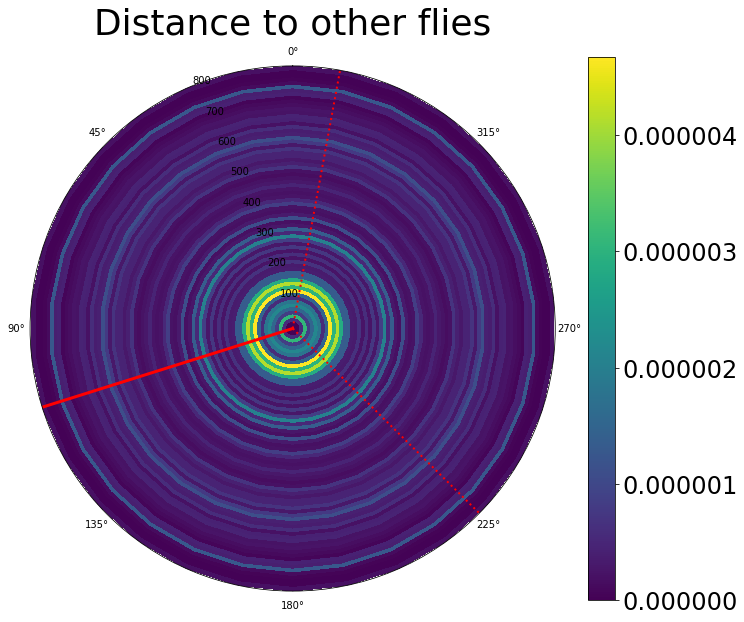

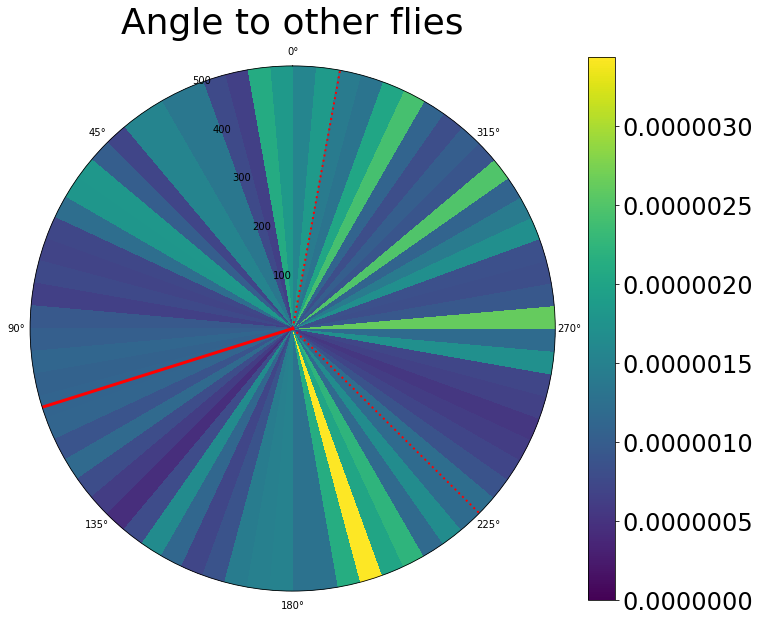

In [2]:
polar_histogram(get_ori_pickle('fly2'), dist_range=800)
polar_histogram(get_ori_pickle('fly2'),distance=False)
# polar_histogram(get_ori_pickle('6flies_2'), force_bin=10)
# polar_histogram(get_ori_pickle('6flies_2'),distance=False, force_bin=50)


from scipy.stats import ks_2samp


stack = relative_set(get_ori_pickle('fly2'))
print(stats.circmean(stack.orientations[~np.isnan(stack.orientations)], high=360))

#Creating two uniform datasets of same statistical caracteristics as our angles and distances
rand_angles = np.random.uniform(0,360,1000)
rand_distances = np.random.uniform(30,800,1000)

print(stats.describe(rand_angles))
print(stats.describe(stack.orientations[~np.isnan(stack.orientations)]))

#Testing to see if our angles and distances are randomly distributed or not
print(ks_2samp(rand_angles, stack.orientations))
print(ks_2samp(rand_distances, stack.dist))
#Our data are indeed not uniform.